# Tutorial for Functions.py

Minimization of the full loss function ($\alpha,\beta,\gamma$ hyperparameters) through nested minimization.

It includes also the optimization of force fields (corresponding to $\alpha,\gamma=\infty$) with data from alchemical $\Delta G$ calculations.

Customized algorithm.

- see https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410 for refinement with only $\alpha,\gamma$ finite and https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423 for refinement with only $\alpha,\beta$ finite;

- see https://pubs.acs.org/doi/full/10.1021/acscentsci.2c00565 for refinement with alchemical calculations (L2 regularization).

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp

In [3]:
from IPython.display import clear_output

import from parent directory

In [4]:
import sys
sys.path.append('../')

In [5]:
from MDRefine import load_data, minimizer, select_traintest, hyper_minimizer, MDRefinement

a simple script to unwrap dictionaries:

In [6]:
def unwrap_dict(d):

    res = []
    
    if isinstance(d, dict):
        for val in d.values():
            res.extend(unwrap_dict(val))
    else:
        if isinstance(d, list): res = d
        else: res = [d]

    return np.hstack(res)

## 1. Ensemble refinement

### a. Load data
Define **infos** dictionary, which specifies required information in order to get data from input files through **load_data**.

see also load_data.ipynb

#### Load observables (no force-field terms and no forward quantities)

In [10]:
infos = {}

# Firstly, define global properties, valid for all the systems:

infos['global'] = {}

# 'name of the folder with data'
infos['global']['path_directory'] = 'DATA'

# system names
system_names = ['AAAA','CAAU']
infos['global']['system_names'] = system_names

# Then, define properties which are specific of each system, like experimental data and observables

for name in system_names:
    infos[name] = {}
    
    # experimental observables (average and uncertainty), corresponding to 'file_name'.npy in DATA/system_name/g_exp/
    # uNOEs values are upper bounds, so specify '<' with ('uNOEs','<')
    infos[name]['g_exp'] = ['NOEs']#, ('uNOEs','<')]
    
    # observables from MD simulations, corresponding to 'file_name'.npy in DATA/system_name/observables/
    # they must correspond also to items of infos[name]['g_exp']
    infos[name]['obs'] = ['NOEs']#, 'uNOEs']

# If some properties are the same for all the systems, you can store them just once in infos['global']

infos['global']['temperature'] = 1 # namely, energies are in unit of k_B T (default value)
# (in this case, you could do this also for 'g_exp' and 'obs')

# Select the stride for the frames (thinner strides will require more time for minimizations; default value = 1)
stride = 1000

In [11]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA


IndexError: list index out of range

#### Include also quantities computed through a **forward model**.

Besides previously defined **infos**:

In [24]:
for name in system_names:
    # include experimental values also for 3J scalar couplings
    infos[name]['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']#, ('uNOEs','<')]

    # include quantities required to compute observables through the forward model
    # they must correspond to 'file_name'.npy in DATA/system_name/forward_qs/
    infos[name]['forward_qs'] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']

# starting values of the forward model coefficients: specify the file name inside DATA/
infos['global']['forward_coeffs'] = 'original_fm_coeffs' # string

Now, define the **forward_model**.

In our case-study, the forward model is given by the **Karplus equations**:

$^3 J_\gamma = A_\gamma \, cos^2\gamma \, - \, B_\gamma \, cos\gamma \, + \, C_\gamma$

with empirical coefficients $A_\gamma,\,B_\gamma,\,C_\gamma$ ($\gamma$ dihedral angles), and analogously for $^3 J_{\beta/\epsilon}$ (same coefficients both for $\beta$ and $\epsilon$ dihedral angles) and $^3J_\nu$ (sugar dihedral angles).

**WARNING**: keys of **forward_qs_out** must correspond to associated g_exp, as specified in infos

In [25]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2-fm_coeffs[1]*forward_qs_cos['backbone1_gamma']+fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2-fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon']+fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2-fm_coeffs[7]*forward_qs_cos['sugar']+fm_coeffs[8] }

    return forward_qs_out

same forward-model function for each system, so put it in infos['global']

In [26]:
infos['global']['forward_model'] = forward_model_fun

In [27]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\alpha$

In [28]:
# use function minimizer with selected data and alpha as input
Result = minimizer(data, alpha = 1)

Let's look at the values contained in the class **Result**

In [13]:
print(vars(Result).keys())

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])


**Comments on the minimization.**

As shown in *Andrea Cesari et al., JCTC 2016*, the optimal ensemble $P$ which minimizes the loss function

$\mathcal{L}[P] = \frac{1}{2}\chi^2[P]+\alpha D_{KL}[P|P_0]$

is $P_{\vec\lambda^*}(x) = \frac{1}{Z_{\vec\lambda^*}} P_0(x) e^{-\vec\lambda^*\cdot\vec g(x)}$ where $\vec\lambda^*$ is the point of minimum of the following function

$\Gamma(\vec\lambda) = \frac{1}{2}\alpha\sum_j\sigma_j^2\lambda_j^2+\log Z_{\vec\lambda}+\vec\lambda\cdot\vec{g}_{exp},$

which fulfils $\mathcal L(P_{\vec\lambda^*}) = -\alpha\Gamma(\vec\lambda^*)$ and

$\lambda_i^* = \frac{\langle g_i \rangle_{P_*}-g_{i,exp}}{\alpha\sigma_{i,exp}^2}$.

The Python function **minimizer** exploits this relationship by minimizing $\Gamma$ (for each system), and then evaluating in detail $\mathcal{L}[P_\lambda]$ at the optimal point found for $\Gamma$ (in order to get $\chi^2$ and $D_{KL}$). To check the success of the minimization of $\Gamma$, you can read the truth value *success of inner minimization* (output message of scipy.optimize.minimize, in **Result.minis[name_sys].success**). The quality of this result is determined by comparing $-\alpha\Gamma(\vec\lambda^*)$ with $\mathcal L(P_{\vec\lambda^*})$, which we know to be equal at the point of minimum; this is reported in **Result.abs_difference**.

In [19]:
for name_sys in data['global'].system_names:
    print(Result.minis[name_sys].success, Result.minis[name_sys].message)

print('\nabsolute differences:\n', Result.abs_difference)

True Optimization terminated successfully.
True Optimization terminated successfully.

absolute differences:
 {'AAAA': DeviceArray(0.00567539, dtype=float64), 'CAAU': DeviceArray(0.00401629, dtype=float64)}


- first of all, the min. value of the loss function **loss**

In [20]:
print('optimal loss: ', Result.loss)
print('time required: ', Result.time)

optimal loss:  157.40786286559697
time required:  22.592878818511963


- then, the optimal ensembles $P^*$ **weights_new** (completely defined by the starting ensembles and by the **min_lambdas** coefficients), together with their (log) normalization factor **logZ_new**. Let's plot them.

Their statistical robustness is evaluated by the Kullback-Leibler divergence from the initial ensembles **D_KL_alpha** as $e^{-D_{KL}[P^*|P_0]}$ (geometric average of the ratio $P^*(x)/P_0(x)$, averaged over $P^*(x)$). Notice the arithmetic average is the effective n. of frames (compared to the total n.), defined as the inverse of the Kish size
$\frac{n_{eff}}{N} = \frac{1}{N\sum_t w_t^2}$).

In [21]:
Result.D_KL_alpha

{'AAAA': DeviceArray(3.82488963, dtype=float64),
 'CAAU': DeviceArray(4.19595699, dtype=float64)}

system AAAA:
effective n. of frames (on the total n.):  0.02182084373353677
logZ:  -268.01362443341077
system CAAU:
effective n. of frames (on the total n.):  0.01505632676196905
logZ:  -222.45035438867598


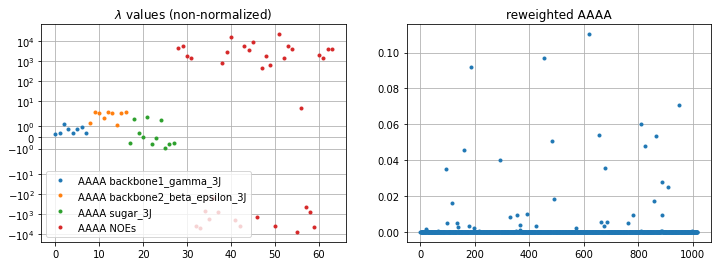

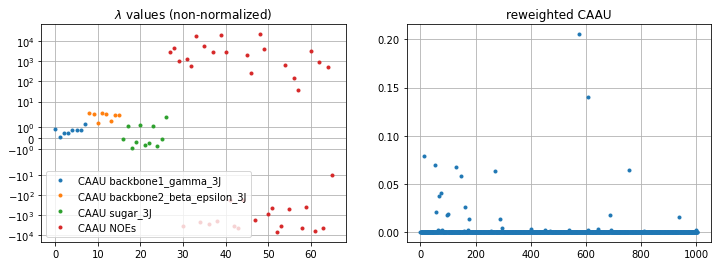

In [22]:
for s in system_names:

    plt.figure(figsize = (12,4))

    plt.subplot(1,2,1)

    l = 0
    for i2,s2 in enumerate(Result.min_lambdas[s].keys()):
        l_new = l+len(Result.min_lambdas[s][s2])
        plt.plot(np.arange(l,l_new),Result.min_lambdas[s][s2],'.',label='%s %s' % (s,s2))
        l = l_new

    plt.title('$\lambda$ values (non-normalized)')
    plt.legend()# loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.yscale('symlog')

    plt.subplot(1,2,2)
    
    plt.plot(Result.weights_new[s],'.')
    plt.title('reweighted %s' % s)
    plt.grid()
    
    n_eff = np.exp(-Result.D_KL_alpha[s])

    print('system %s:' % s)
    print('effective n. of frames (on the total n.): ', n_eff)
    print('logZ: ', Result.logZ_new[s])


- finally, let's look at the average values of the observables in the new ensembles **av_g** and associated **chi2**; compare with experimental values data.gexp and with average values of the original ensembles.

chi2:  17.464389378171056
observables (first names in list):
 [["A1-H1'" 'A1-H8']
 ["A1-H1'" 'A2-H8']
 ['A1-H2' "A2-H1'"]
 ["A1-1H2'" 'A1-H8']
 ["A1-1H2'" "A2-H1'"]]


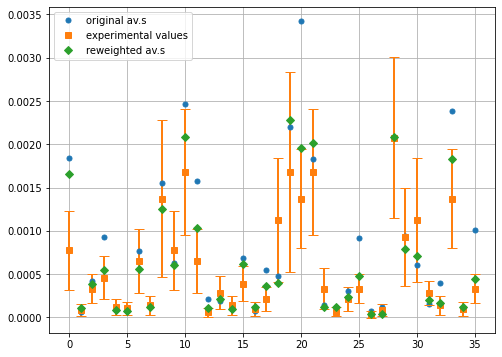

In [23]:
s1 = 'AAAA'
s2 = 'NOEs'

print('chi2: ',Result.chi2[s1][s2])
print('observables (first names in list):\n',data[s1].names[s2][:5])

plt.figure(figsize=(8,6))

# compute average values with original ensemble
g_mean = np.matmul(data[s1].weights, data[s1].g[s2])

plt.plot(g_mean,'.',label='original av.s',markersize=10)

plt.plot(data[s1].gexp[s2][:,0],'s',label='experimental values')
plt.errorbar(np.arange(len(data[s1].gexp[s2][:,0])), data[s1].gexp[s2][:,0], data[s1].gexp[s2][:,1], fmt = ' ',
    color = 'tab:orange', capsize = 5, lw = 2)

plt.plot(Result.av_g[s1][s2], 'D', label = 'reweighted av.s')

plt.legend()
plt.grid()

### c. Determine optimal hyper parameter $\alpha$ through cross validation (scan over $\alpha$)

The loss function for Ensemble Refinement, previously introduced, has one hyper-parameter $\alpha$ which needs to be fixed. This hyper-parameter tunes the reliability given to the original ensemble in spite of the trust to experimental data.

Suitable values of $\alpha$ can be determined through cross validation procedure: randomly split the full data set into training and test set, then select the value of $\alpha$ which minimizes the $\chi^2$ on the test set (either same observables as in training but new frames or new observables).

Let's perform just one splitting into training/test set (as an example) and scan over different values of $\alpha$ (in logarithmic scale).

The function **select_traintest** can be used to get **data_train** and **data_test** by simply passing a **random_state** (a random integer), which randomly selects **test_obs** and **test_frames**.

In [8]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = 1)

Input random_state employed both for test_obs and test_frames


In [25]:
print('test observables:\n', test_obs)
print('test frames:\n', test_frames)

test observables:
 {'AAAA': {'backbone2_beta_epsilon_3J': DeviceArray([0, 3, 4, 6], dtype=int64), 'sugar_3J': DeviceArray([2, 8], dtype=int64), 'NOEs': DeviceArray([ 5, 10, 11, 23, 29, 30, 35], dtype=int64), 'backbone1_gamma_3J': DeviceArray([], dtype=int64)}, 'CAAU': {'backbone1_gamma_3J': DeviceArray([3], dtype=int64), 'backbone2_beta_epsilon_3J': DeviceArray([3], dtype=int64), 'sugar_3J': DeviceArray([7, 8], dtype=int64), 'NOEs': DeviceArray([ 1,  2,  5, 15, 16, 25, 28, 30, 33], dtype=int64)}}
test frames:
 {'AAAA': DeviceArray([   5,    6,   16,   22,   23,   24,   28,   31,   35,   40,
               49,   53,   55,   61,   63,   71,   75,   79,  100,  101,
              104,  105,  106,  113,  118,  134,  140,  143,  144,  162,
              173,  176,  178,  193,  203,  204,  205,  207,  213,  224,
              225,  234,  238,  240,  254,  255,  256,  261,  263,  266,
              276,  281,  289,  309,  311,  314,  320,  325,  328,  330,
              339,  342,  349,  367, 

Default values for the fraction of test observables and frames are $20\%$ for both (you can change this ratio by selecting **test_frames_size** and/or **test_obs_size** as input variables). By default, test observables are evaluated only on test frames; you can also consider both on training and test frames, by setting **if_all_frames** = True.

In [25]:
data_train, data_test, test_obs, test_frames = select_traintest(data, test_frames_size = 0.2, test_obs_size = 0.3,
    random_state = 4, if_all_frames = True)

Input random_state employed both for test_obs and test_frames


({'global': <Functions.load_data.<locals>.data_global_class at 0x7f3a654e9f28>,
  'AAAA': Functions.select_traintest.<locals>.class_train,
  'CAAU': Functions.select_traintest.<locals>.class_train},
 {'global': <Functions.load_data.<locals>.data_global_class at 0x7f3a654e9f28>,
  'AAAA': Functions.select_traintest.<locals>.class_test,
  'CAAU': Functions.select_traintest.<locals>.class_test},
 {'AAAA': {'backbone1_gamma_3J': DeviceArray([1, 2, 3, 5], dtype=int64),
   'backbone2_beta_epsilon_3J': DeviceArray([1], dtype=int64),
   'sugar_3J': DeviceArray([0, 2, 3, 7], dtype=int64),
   'NOEs': DeviceArray([ 2,  3,  5, 22, 25, 26, 27, 29, 30, 32], dtype=int64)},
  'CAAU': {'backbone1_gamma_3J': DeviceArray([0, 2, 3], dtype=int64),
   'backbone2_beta_epsilon_3J': DeviceArray([0, 2, 3, 4], dtype=int64),
   'sugar_3J': DeviceArray([0, 2, 3, 8], dtype=int64),
   'NOEs': DeviceArray([ 8, 11, 14, 23, 28, 30, 35, 36, 38], dtype=int64)}},
 {'AAAA': DeviceArray([   4,   23,   31,   36,   38,   43, 

Alternatively, we can also directly pass test_obs and test_frames.

In [44]:
out = select_traintest(data, test_obs = test_obs, test_frames = test_frames)

data_train = out[0]
data_test = out[1]

Now, let's scan over different values of $\alpha$ for a given partition of the full data set into training and test set. Let's work directly with logarithms in base 10, to explore several orders of magnitude for $\alpha$.

We can also pass data_test as input to minimizer: after the minimization of the loss function on data_train, we evaluate corresponding properties (such as $D_{KL}$, $\chi^2$, loss function) on test frames and $\chi^2$ on test observables.

In [9]:
log10_alphas = np.arange(-2, 7, 1)

Results = {}

for log10_alpha in log10_alphas:
    print(log10_alpha)

    alpha = 10**np.float64(log10_alpha)
    Results[log10_alpha] = minimizer(data_train, alpha = alpha, data_test = data_test)

    clear_output()

In [10]:
vars(Results[log10_alpha]).keys()

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'loss_test', 'D_KL_alpha_test', 'abs_difference_test', 'av_g_test', 'chi2_test', 'logZ_new_test', 'weights_new_test', 'avg_new_obs', 'chi2_new_obs'])

For each value of the hyper-parameter, we now have corresponding quantities for test frames (such as **loss_test**, **D_KL_alpha_test**, **av_g_test**, **chi2_test**, **weights_new_test**) and for test observables (**avg_new_obs** and **chi2_new_obs**).

Let's compare the loss function for training set and test set (new frames):
- at high values of $\alpha$, the two values almost overlap;
- decreasing $\alpha$, both the two loss functions decrease, except that the one on the test at a certain point starts to increase marking overfitting.

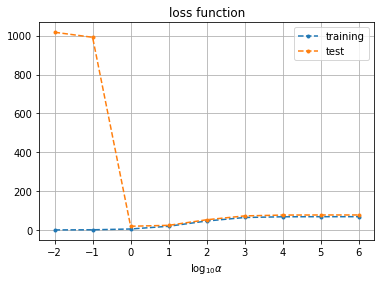

In [11]:
loss = [Results[log10_alpha].loss for log10_alpha in log10_alphas]
loss_test = [Results[log10_alpha].loss_test for log10_alpha in log10_alphas]

plt.title('loss function')
plt.plot(log10_alphas, loss, '.--', label = 'training')
plt.plot(log10_alphas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

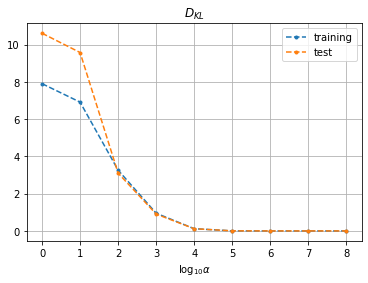

In [12]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha)) for log10_alpha in log10_alphas]
D_KL_test = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha_test)) for log10_alpha in log10_alphas]

plt.title('$D_{KL}$')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

Now, the $\chi^2$, including also test observables

In [13]:
chi2s = [np.sum(unwrap_dict(Results[log10_alpha].chi2)) for log10_alpha in log10_alphas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_test)) for log10_alpha in log10_alphas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_new_obs)) for log10_alpha in log10_alphas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

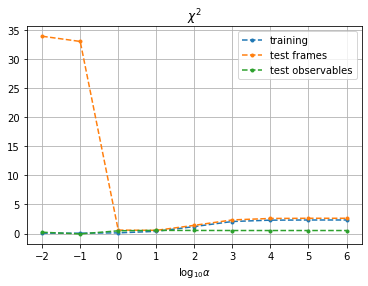

In [14]:
plt.plot(log10_alphas, red_chi2s, '.--', label = 'training')
plt.plot(log10_alphas, red_chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_alphas, red_chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\alpha$')
plt.grid()

### d. Determine optimal hyper parameter $\alpha$ through cross validation (automatic optimization)

Rather than performing a scan over the hyper-parameter $\alpha$, we now minimize the $\chi^2$ on the test set (computed at optimal parameters obtained in training) with respect to $\alpha$.

In [9]:
starting_alpha = 1e2

by default, which_set = 'validation' (rather than 'test' or 'training'), namely evaluate $\chi^2$ on same observables as training but new frames of the trajectory

In [10]:
mini = hyper_minimizer(data, starting_alpha = starting_alpha, random_states = 2, which_set = 'validation', gtol = 0.5)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(2., dtype=float64)] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [2.] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [0.99] ['alpha']
tot chi2:  425.00547800983844
tot gradient:  [-1826.18114941]
log10 hyperpars:  [1.6329151] ['alpha']
tot chi2:  126.70090220074779
tot gradient:  [103.53961778]
log10 hyperpars:  [1.01026981] ['alpha']
tot chi2:  390.70284260061294
tot gradient:  [-1677.36149732]
log10 hyperpars:  [1.50044572] ['alpha']
tot chi2:  117.71717904095316
tot gradient:  [21.76320493]
log10 hyperpars:  [1.46519156] ['alpha']
tot chi2:  117.56919878055263
tot gradient:  [-12.86928899]
log10 hyperpars:  [1.47829186] ['alpha']
tot chi2:  117.4288039078597
tot gradient:  [1.38731611]
log10 hyperpars:  [1.47701706] ['alpha']
tot chi2:  117.4525033

In [11]:
mini

      fun: 117.4074816543556
 hess_inv: array([[0.00122096]])
      jac: array([-0.31450289])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([1.47659801])

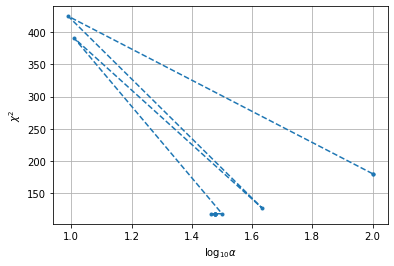

In [24]:
x = mini['intermediate'].log10_hyperpars
y = mini['intermediate'].av_chi2

plt.plot(x,y,'.--')
plt.xlabel(r'$\log_{10}\alpha$')
plt.ylabel('$\chi^2$')
plt.grid()

In [18]:
optimal_alpha = 10**(mini.x)

The optimal hyper-parameter is $\alpha \simeq 10^{1.09}$. We can now minimize the loss function on the whole data set in order to get more statistically robust results. Provided the estimation of the optimal hyper-parameters is robust enough, we can load the full data set without stride (it will take more time).

In [19]:
data = load_data(infos)

loading data from directory...
loading  AAAA
loading  CAAU
done


In [20]:
Result = minimizer(data, alpha = optimal_alpha)

In [21]:
vars(Result)

{'loss': DeviceArray([40.16542256], dtype=float64),
 'min_lambdas': {'AAAA': {'NOEs': DeviceArray([ 150.73992103,  -67.29285849,  105.62119535,  118.96876618,
                 -74.04540148, -102.87904109,   37.76755821,  -23.09866382,
                  10.40497866,  -30.11556459,   47.2407546 ,   97.55062434,
                1033.66361603,  -76.13445458, -119.69251423,  182.8412221 ,
                 -41.69269727,  349.17365518,  -39.84692591,   15.85069759,
                  91.86738887,   23.85272636,  -97.62859541,  614.99665463,
                 154.34680669,  303.89155513,  402.68529294,  191.27067489,
                  -1.15469979,  -20.86065066,  -19.20484019, -155.03477145,
                 169.41074214,   62.59969065,  106.82633384,  347.63227384],            dtype=float64)},
  'CAAU': {'NOEs': DeviceArray([ 116.99604616,   28.40984552,   54.57910406, -160.33853852,
                   7.83028943,   63.83780474,  502.50050988,  -83.25424726,
                 -11.50902254, -123.

Look at section b) for analysis of Result.

### do all together

In [22]:
Result = MDRefinement(infos, stride = stride, starting_alpha = 1e2, random_states = 2, which_set = 'validation', gtol = 0.5)

loading data from directory...
loading  AAAA
loading  CAAU
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(2., dtype=float64)] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [2.] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [0.99] ['alpha']
tot chi2:  425.00547800983844
tot gradient:  [-1826.18114941]
log10 hyperpars:  [1.6329151] ['alpha']
tot chi2:  126.70090220074779
tot gradient:  [103.53961778]
log10 hyperpars:  [1.01026981] ['alpha']
tot chi2:  390.70284260061294
tot gradient:  [-1677.36149732]
log10 hyperpars:  [1.50044572] ['alpha']
tot chi2:  117.71717904095316
tot gradient:  [21.76320493]
log10 hyperpars:  [1.46519156] ['alpha']
tot chi2:  117.56919878055263
tot gradient:  [-12.86928899]
log10 hyperpars:  [1.47829186] ['alpha']
tot chi2:  117.4

In [23]:
vars(Result)

{'loss': DeviceArray(40.16542256, dtype=float64),
 'min_lambdas': {'AAAA': {'NOEs': DeviceArray([ 150.73992103,  -67.29285849,  105.62119535,  118.96876618,
                 -74.04540148, -102.87904109,   37.76755821,  -23.09866382,
                  10.40497866,  -30.11556459,   47.2407546 ,   97.55062434,
                1033.66361603,  -76.13445458, -119.69251423,  182.8412221 ,
                 -41.69269727,  349.17365518,  -39.84692591,   15.85069759,
                  91.86738887,   23.85272636,  -97.62859541,  614.99665463,
                 154.34680669,  303.89155513,  402.68529294,  191.27067489,
                  -1.15469979,  -20.86065066,  -19.20484019, -155.03477145,
                 169.41074214,   62.59969065,  106.82633384,  347.63227384],            dtype=float64)},
  'CAAU': {'NOEs': DeviceArray([ 116.99604616,   28.40984552,   54.57910406, -160.33853852,
                   7.83028943,   63.83780474,  502.50050988,  -83.25424726,
                 -11.50902254, -123.38

## 2. Force-field refinement

### a. Load data

Load experimental data, observables and forward model as previously done.

Load also force-field correction terms and corresponding functional form.

In [15]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = 'DATA'
infos['global']['system_names'] = ['AAAA','CAAU']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs']
infos['global']['forward_qs'] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [16]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2-fm_coeffs[1]*forward_qs_cos['backbone1_gamma']+fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2-fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon']+fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2-fm_coeffs[7]*forward_qs_cos['sugar']+fm_coeffs[8] }

    return forward_qs_out

same forward-model function for each system, so put it in infos['global']

In [17]:
infos['global']['forward_model'] = forward_model_fun

Now, the force-field correction terms: we selected (for each molecule)
\begin{equation}
\beta\Delta V = \sum_{i}\Bigl[\phi_1\cos\alpha_i + \phi_2\sin\alpha_i + \phi_3 \cos \zeta_i + \phi_4 \sin\zeta_i\Bigr]
\end{equation}
where the sum is over residues. Since numpy arrays ff_terms have columns

['sinalpha[0]', 'sinalpha[1]', 'sinalpha[2]', 'sinzeta[0]', 'sinzeta[1]', 'sinzeta[2]', 'cosalpha[0]', 'cosalpha[1]', 'cosalpha[2]', 'coszeta[0]', 'coszeta[1]', 'coszeta[2]'],

such correction is defined by the following function (use jax.numpy).

In [18]:
import jax.numpy as jnp

In [19]:
def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

In [20]:
infos['global']['ff_correction'] = ff_correction
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

In [21]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA
loading  CAAU
done


Now, define the regularization for the force-field refinement. We can choose among 'plain l2' (acting on the coefficients) or 'KL divergence' (acting directly on the ensemble).

In [13]:
regularization = {'force_field_reg': 'KL divergence'}

### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\beta$

In [14]:
# use function minimizer with selected data and alpha as input
Result = minimizer(data, regularization = regularization, beta = 1)

In [26]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

Besides quantities described in the previous section (such as: **av_g**, **chi2**, **weights_new**, **logZ_new**), we now have:
- output of minimization **mini**;
- optimal force-field correction parameters **pars**;
- value of force-field regularization **reg_ff**.

In [19]:
Result.pars

array([ 0.19294133, -0.316137  ,  0.30447543,  0.22680487])

In [28]:
Result.mini

      fun: 285.0834500891217
 hess_inv: array([[ 5.20491478e-02, -8.89295688e-02, -5.00415048e-02,
        -2.23536762e-03],
       [-8.89295688e-02,  1.12747644e+00,  1.16060221e-01,
        -1.68801647e-02],
       [-5.00415048e-02,  1.16060221e-01,  5.61942163e-02,
         7.66569900e-04],
       [-2.23536762e-03, -1.68801647e-02,  7.66569900e-04,
         2.57011281e-02]])
      jac: array([-4.58613412e-05, -3.04716135e-06, -7.24710956e-05, -5.68219475e-05])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 26
     njev: 36
   status: 0
  success: True
        x: array([ 0.46316927, -3.50501963, -0.31937378,  1.15776919])

In [27]:
Result.reg_ff

{'AAAA': DeviceArray(1.25078007, dtype=float64),
 'CAAU': DeviceArray(1.5893921, dtype=float64)}

### c. Determine optimal hyper parameter $\beta$ through cross validation (scan over $\beta$)

In [16]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = 2)

Input random_state employed both for test_obs and test_frames


In [17]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization = regularization, beta = beta, data_test = data_test)

    print(Results[log10_beta].loss)

    clear_output()

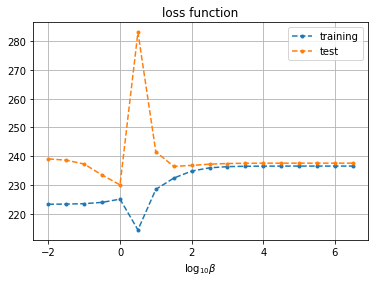

In [18]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_test = [Results[log10_beta].loss_test for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

In [19]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_test)) for log10_beta in log10_betas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

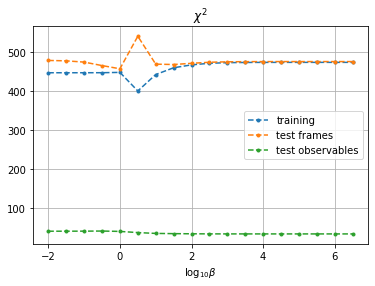

In [20]:
plt.plot(log10_betas, chi2s, '.--', label = 'training')
plt.plot(log10_betas, chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_betas, chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

What's happened at random_seed = 2? With this choice of training/test set, the loss function in training is not (always) increasing with $\beta$, however the minimization has always success.

In [21]:
print([Results[log10_beta].mini.success for log10_beta in log10_betas])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


Since the loss function at low values of $\beta$ is higher than the one at $\log_{10}\beta = 0.5$ (and the optimal loss is always increasing with $\beta$), this means for such $\beta$ we ended up in another (local) minimum. So, let's use optimal coefficients found at  $\log_{10}\beta = 0.5$ as starting point for the minimization (**starting_pars**).

In [22]:
starting_pars = Results[0.5].pars

In [23]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization = regularization, beta = beta, data_test = data_test, starting_pars = starting_pars)

    print(Results[log10_beta].loss)

    clear_output()

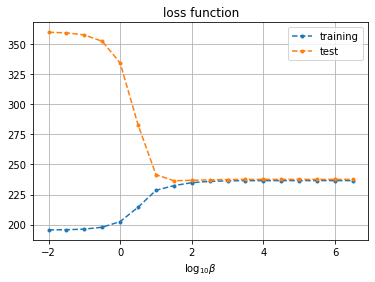

In [24]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_test = [Results[log10_beta].loss_test for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

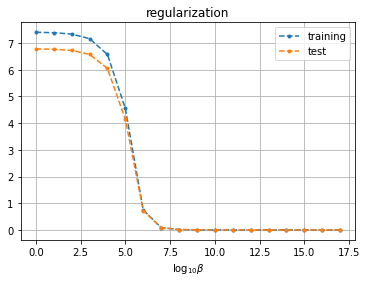

In [25]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_beta].reg_ff)) for log10_beta in log10_betas]
D_KL_test = [np.sum(unwrap_dict(Results[log10_beta].reg_ff_test)) for log10_beta in log10_betas]

plt.title('regularization')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

In [26]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_test)) for log10_beta in log10_betas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

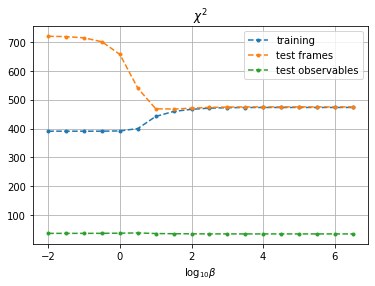

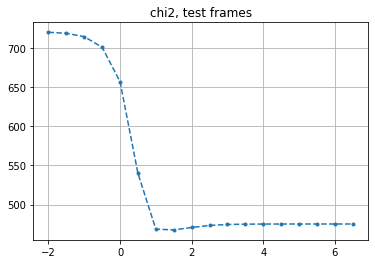

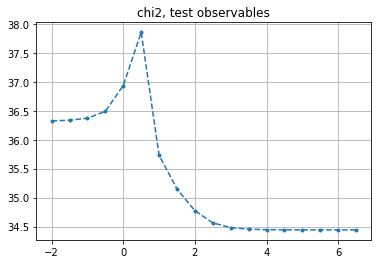

In [27]:
plt.plot(log10_betas, chi2s, '.--', label = 'training')
plt.plot(log10_betas, chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_betas, chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

plt.figure()
plt.plot(log10_betas, chi2s_test1, '.--', label = 'test frames')
plt.title('chi2, test frames')
plt.grid()

plt.figure()
plt.plot(log10_betas, chi2s_test2, '.--', label = 'test observables')
plt.title('chi2, test observables')
plt.grid()

### d. Determine optimal hyper parameter $\beta$ through cross validation (automatic optimization)

Let's take the same random_state used for the scan. Here **random_states** can be a list of values or an integer; if it is an integer, you will take values in np.arange(random_states).

In [28]:
starting_beta = 1

mini = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = [2], starting_pars = starting_pars)

Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(0., dtype=float64)] ['beta']
tot chi2:  657.0989509863348
tot gradient:  [-152.45869821]
log10 hyperpars:  [0.] ['beta']
tot chi2:  657.0989509863348
tot gradient:  [-152.45869821]
log10 hyperpars:  [1.01] ['beta']
tot chi2:  468.3693258698372
tot gradient:  [-22.5461002]
log10 hyperpars:  [1.1852837] ['beta']
tot chi2:  467.07360566704546
tot gradient:  [-1.34951948]
log10 hyperpars:  [1.19644346] ['beta']
tot chi2:  467.0602418806326
tot gradient:  [-1.0524543]
log10 hyperpars:  [1.22209289] ['beta']
tot chi2:  467.0413456162542
tot gradient:  [-0.42517636]


In [29]:
mini

      fun: 467.0413456162542
 hess_inv: array([[0.03756671]])
      jac: array([-0.42517636])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([1.22209289])

In [34]:
starting_beta = 10**mini.x

mini2 = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = [2], which_set = 'test', starting_pars = starting_pars)


Input random_state employed both for test_obs and test_frames


/u/i/igilardo/3_alphabetagamma/Functions.py:2178: OptimizeWarning: Unknown solver options: maxfev
  hyper_mini = minimize(hyper_function, log10_hyperpars0, args = args, method = 'BFGS', jac = True, options = {'gtol': gtol, 'maxfev': 20})#, 'ftol': 0.1})


log10 hyperpars:  [1.22209289] ['beta']
New evaluation:
loss:  275.9155436501145
gradient:  [ 15.35127511  -9.04572861 -17.39103002  15.82186062] 

New evaluation:
loss:  271.2288368007547
gradient:  [ 21.55634479 -15.11850864  34.20302808 -18.6338733 ] 

New evaluation:
loss:  272.357448770612
gradient:  [-48.31790364 -15.3158465  -31.55294149 -12.06668938] 

New evaluation:
loss:  268.69454038601975
gradient:  [ -3.94195706 -15.14120574   9.81590609 -15.85437518] 

New evaluation:
loss:  263.73416077611796
gradient:  [ -4.41017571 -14.61961542   8.9840051  -12.96736957] 

New evaluation:
loss:  248.01464402792865
gradient:  [ -3.9952376  -11.95298115   9.40247393   1.81615909] 

New evaluation:
loss:  238.2293291226762
gradient:  [-13.22534213  19.0581175  -13.64305686   0.45961333] 

New evaluation:
loss:  235.62816325607469
gradient:  [-6.78958971 -7.20917815 -1.98527689 -3.62422861] 

New evaluation:
loss:  275.5164990990347
gradient:  [10.03510966 66.90537498 40.36704847 16.23575

In [35]:
mini2

      fun: 132.21272885005425
 hess_inv: array([[0.04261599]])
      jac: array([0.27195238])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([1.15049021])

#### multiple seeds
in order to get more robust results and avoid local minima 

Let's use 2 random_states [0, 1]

In [36]:
starting_beta = 1

mini = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = 2)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [0.] ['beta']
New evaluation:
loss:  232.03396939608317
gradient:  [-71.76903903  -5.50396973 -51.47297004 -14.96441254] 

New evaluation:
loss:  209.3237551897244
gradient:  [ 1.91964428 -0.2070328   7.12258622 -4.61135859] 

New evaluation:
loss:  754.3009782677531
gradient:  [100.18299117 -38.11978997   8.27176677  55.42594161] 

New evaluation:
loss:  208.56882815017454
gradient:  [ 1.89118245  0.90379216  7.67540293 -2.55457306] 

New evaluation:
loss:  207.06287927808435
gradient:  [ 2.38351279  0.41791025  8.34649019 -1.6563974 ] 

New evaluation:
loss:  207.134978140154
gradient:  [  2.76218824   7.17962407 -18.06578377   9.25915916] 

New evaluation:
loss:  204.56412161010527
gradient:  [2.56130963 1.60978088 4.60399415 2.2174964 ] 

New evaluation:
loss:  209.0164700744682
gradient:  [  3.32259559  10.61258435 -29.4412328   10.7129315 ]

In [37]:
mini

      fun: 887.3288621393083
 hess_inv: array([[0.02972008]])
      jac: array([-0.38020489])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([0.4458335])

In [46]:
log10_betas = np.arange(-2, 7, 0.5)
random_states = np.arange(2)

Results = {}

for random_state in random_states:
    
    Results[random_state] = {}

    data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = random_state)

    for log10_beta in log10_betas:

        print(random_state, log10_beta)

        beta = 10**np.float64(log10_beta)
        Results[random_state][log10_beta] = minimizer(data_train, regularization = regularization, beta = beta, data_test = data_test)

        clear_output()

In [47]:
chi2s = []
chi2s_test1 = []
chi2s_test2 = []

for random_state in random_states:

    chi2s.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2)) for log10_beta in log10_betas])
    chi2s_test1.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2_test)) for log10_beta in log10_betas]) # .chi2_test
    chi2s_test2.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2_new_obs)) for log10_beta in log10_betas]) # .chi2_test


In [50]:
np.sum(chi2s, axis = 0)

array([809.5228564 , 809.52341081, 809.52885058, 809.58025051,
       810.03572158, 814.556873  , 826.18925646, 846.9433294 ,
       875.85522829, 894.73193725, 902.54606228, 905.24866257,
       906.12830864, 906.40904183, 906.49807601, 906.52625701,
       906.53517122, 906.5379904 ])

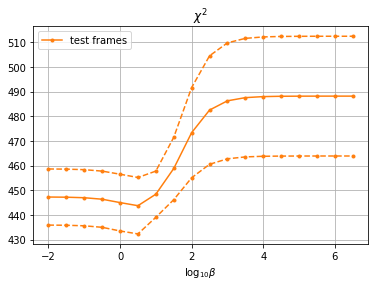

In [56]:
# plt.plot(log10_betas, np.mean(chi2s, axis = 0), '.-', label = 'training', color = 'tab:blue')
plt.plot(log10_betas, np.mean(chi2s_test1, axis = 0), '.-', label = 'test frames', color = 'tab:orange')
# plt.plot(log10_betas, np.mean(chi2s_test2, axis = 0), '.-', label = 'test observables', color = 'tab:green')

for i in range(len(chi2s)):
    # plt.plot(log10_betas, chi2s[i], '.--', color = 'tab:blue')
    plt.plot(log10_betas, chi2s_test1[i], '.--', color = 'tab:orange')
    # plt.plot(log10_betas, chi2s_test2[i], '.--', color = 'tab:green')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

## 2b. Force-field refinement - alchemical calculations

### a. Load data

In [7]:
infos = {}

infos['global'] = {}
infos['global']['temperature'] = 2.476
infos['global']['path_directory'] = '../../DATA_alchemical'

# for alchemical calculations, we have both system_names (names of each molecular system) and cycle_names (names of
# the thermodynamic cycles); each cycle is composed by 4 systems; system_names with corresponding thermodynamic
# cycle must be defined as 'cycle_name'+'_'+s for s in ['AS','AD','MS','MD'] (A for adenosine, M for methylated;
# S for single, D for double strand). The experimental DG is between (AS, AD) and (MS, MD), the simulated one is
# between (AS, MS) and (AD, MD).

infos['global']['cycle_names'] = ['A1','A2','A3','A4','A5']#,'B1','B2','B3','B4','B5']
# infos['global']['cycle_names'] = ['A4','A5']

system_names = []
for name in infos['global']['cycle_names']:
    for string in ['AS','AD','MS','MD']:
        system_names.append(name+'_'+string)

infos['global']['system_names'] = system_names

# force-field correction terms

n_charges = 5

infos['global']['names_ff_pars'] = ['DQ %i' % (i+1) for i in range(n_charges)] + ['cos eta']

columns = []
for i in range(n_charges):
    columns.append('DQ %i' % (i+1))
    columns.append('DQ %i%i' % (i+1,i+1))
for i in range(n_charges):
    for j in range(i+1,n_charges):
        columns.append('DQ %i%i' % (i+1,j+1))
columns.append('cos eta')

# only methylated (M) systems have a force-field correction

for name in system_names: infos[name] = {}

for name in infos['global']['cycle_names']:
    for s in ['D','S']:
        infos[name + '_M' + s]['ff_terms'] = columns

define the force-field correction:
- use jax.numpy rather than numpy in order to do automatic differentiation
- phi is: ['DQ %i' for i in range(n_charges)] + ['cos eta']
- phi_vector is

['DQ 1', 'DQ 11', 'DQ 2', 'DQ 22', 'DQ 3', 'DQ 33', 'DQ 4', 'DQ 44', 'DQ 5', 'DQ 55', 'DQ 12', 'DQ 13', 'DQ 14', 'DQ 15', 'DQ 23', 'DQ 24', 'DQ 25', 'DQ 34', 'DQ 35', 'DQ 45', 'cos eta']

where 2 numbers (such as 'DQ 11' or 'DQ 23') mean the product 'DQ 1 * DQ 1' or 'DQ 2 * DQ 3'.

In [8]:
import jax.numpy as jnp

In [9]:
def ff_correction(phi, ff_terms):

    n_charges = 5

    phi_vector = []
    for i in range(n_charges):
        phi_vector.extend([phi[i], phi[i]**2])
    for i in range(n_charges):
        for j in range(i+1,n_charges):
            phi_vector.append(phi[i]*phi[j])
    phi_vector.append(phi[-1])
    phi_vector = jnp.array(phi_vector)

    correction = jnp.matmul(ff_terms, phi_vector)

    return correction

In [10]:
for k in system_names:
    if k[-2] == 'M': 
        infos[k]['ff_correction'] = ff_correction

In [11]:
data = load_data(infos)

loading data from directory...
loading  A1_AS
loading  A1_AD
loading  A1_MS
loading  A1_MD
loading  A2_AS
loading  A2_AD
loading  A2_MS
loading  A2_MD
loading  A3_AS
loading  A3_AD
loading  A3_MS
loading  A3_MD
loading  A4_AS
loading  A4_AD
loading  A4_MS
loading  A4_MD
loading  A5_AS
loading  A5_AD
loading  A5_MS
loading  A5_MD
done


Define regularization. Rather than 'plain l2', we now have a constraint due to the requirement $\sum_{i=0}^5 \Delta Q_i + 2\Delta Q_4 = 0$ (total charge constant, with 3 $Q_4$ charges), so we have defined 'constraint 1' as regularization in Functions.py

\begin{equation}
\sum_{i=0}^4 \Delta Q_i^2 + \Delta Q_5^2 = \sum_{i=0}^4 \Delta Q_i^2 + \Bigl(\sum_{i=0}^4 \Delta Q_i + 2 \Delta Q_4\Bigr)^2.
\end{equation}

In [13]:
regularization = {'force_field_reg': 'constraint 2'}

It can also be defined by the user

In [19]:
def my_ff_reg(pars):
    lossf_reg = jnp.sum(pars[:-1]**2) + (np.sum(pars[:-1]) + 2*pars[4])**2  # + pars[-1]**2
    return lossf_reg

In [20]:
regularization = {'force_field_reg': my_ff_reg}

In order to avoid numerical issues, put to zero the force-field correction terms corresponding to zero original weights; you could also this in a different way, by selecting only frames with non-zero weights, but then you would have to take this into account when computing the relative entropy or the Kish sample size.

In [21]:
for s in data['global'].system_names:
    # BE CAREFUL!!!
    # if you do this, then when you compute the relative entropy or Kish size,
    # you have to take into account how many zero frames there was

    # wh = np.argwhere(data.weights[s]!=0).flatten()

    # data.weights[s] = data.weights[s][wh]
    # if s in data.f.keys():
    #     data.f[s] = data.f[s].iloc[wh]

    # otherwise, you can put to zero the corresponding force-field correction terms

    if hasattr(data[s], 'f'):
        wh = np.argwhere(data[s].weights == 0).flatten()
        data[s].f[wh] = 0

Valerio put uncertainties = 1

In [22]:
for s in data['global'].cycle_names:
    data[s].gexp_DDG[1] = 1

### b. Minimize the loss function and analyse the results - scan over $\beta$

In [12]:
betas = np.array([0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000, 100000])

without parallelization

with parallelization (faster)

In [27]:
from joblib import Parallel, delayed

In [28]:
Results = Parallel(n_jobs=len(betas), verbose=1)(delayed(minimizer)(
        data, regularization=regularization, beta=beta) for beta in betas)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   2 out of  14 | elapsed:  1.9min remaining: 11.4min
[Parallel(n_jobs=14)]: Done  14 out of  14 | elapsed:  5.1min finished


5 min with parallelization, rather than 28 min

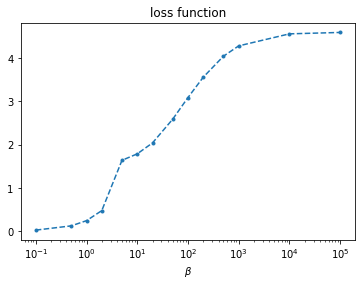

In [29]:
loss = [Results[i].loss for i in range(len(Results))]

plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.show()

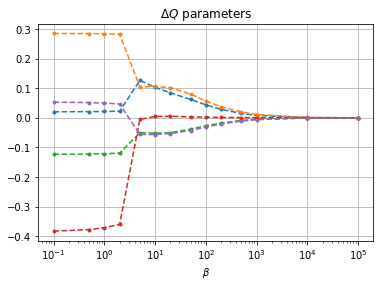

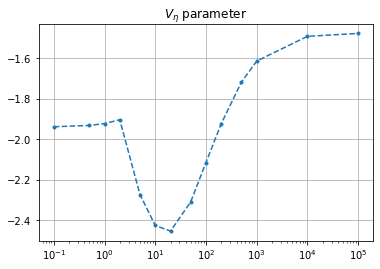

In [30]:
plt.plot(betas, [Results[i].pars[:-1] for i in range(len(Results))], '.--')
plt.grid()
plt.xscale('log')
plt.title('$\Delta Q$ parameters')
plt.xlabel(r'$\beta$')

plt.figure()
plt.plot(betas, [Results[i].pars[-1] for i in range(len(Results))], '.--')
plt.xscale('log')
plt.grid()
plt.title('$V_\eta$ parameter')
plt.show()

### Comparison with relative entropy regularization

In [31]:
regularization = {'force_field_reg': 'KL divergence'}

In [ ]:
Results = Parallel(n_jobs=len(betas), verbose=1)(delayed(minimizer)(
        data, regularization=regularization, beta=beta) for beta in betas)

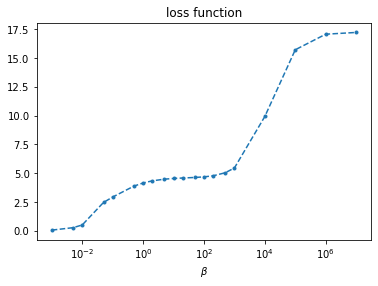

In [36]:
loss = [Results[beta].loss for beta in betas]

plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.show()

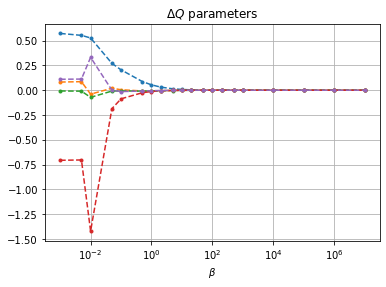

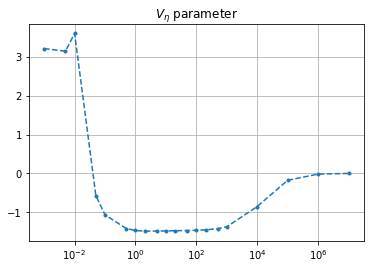

In [39]:
plt.plot(betas, [Results[beta].pars[:-1] for beta in betas], '.--')
plt.grid()
plt.xscale('log')
plt.title('$\Delta Q$ parameters')
plt.xlabel(r'$\beta$')

plt.figure()
plt.plot(betas, [Results[beta].pars[-1] for beta in betas], '.--')
plt.xscale('log')
plt.grid()
plt.title('$V_\eta$ parameter')
plt.show()
